# Actividad Comercial

## commercial_activity_df
|Variable|Explicación|
|---|---|
|*active_customer*| Indicador de actividad del cliente en nuestra aplicación
|*entry_channel*| Canal de captación del cliente
|*entry_date*| Fecha en la que realizó la primera contratación a través de easyMoney
|*segment*| Segmento comercial del cliente
|*pk_cid*| Identificador de cliente
|*pk_partition*| Fecha de ingesta de los datos

## Importacion de librerias

In [76]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("Spectral")
import warnings
warnings.filterwarnings('ignore')

## Lectura de datos

In [77]:
ca_df = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/commercial_activity_df.parquet')

## Funcion para tabla de informacion

In [78]:
def build_my_info_table(df):
    # Seleccionar las columnas numéricas del DataFrame
    numerical_columns = df.select_dtypes(include=[np.number])
    
    # Crear un DataFrame con información detallada sobre las columnas
    df_info = pd.DataFrame({
        # Nombre de la columna
        'column':   [col             for col in df.columns],
        # Tipo de datos de la columna
        'dtype':    [df[col].dtype   for col in df.columns],
        # Número de valores no nulos en la columna
        'count':    [df[col].count() for col in df.columns],
        
        # Estadísticas descriptivas para columnas numéricas
        'mean':     [round(df[col].mean(), 1)         if col in numerical_columns else '' for col in df.columns],
        'std':      [round(df[col].std(), 1)          if col in numerical_columns else '' for col in df.columns],
        'min':      [round(df[col].min(), 1)          if col in numerical_columns else '' for col in df.columns],
        '25%':      [round(df[col].quantile(0.25), 1) if col in numerical_columns else '' for col in df.columns],
        '50%':      [round(df[col].median(), 1)       if col in numerical_columns else '' for col in df.columns],
        '75%':      [round(df[col].quantile(0.75), 1) if col in numerical_columns else '' for col in df.columns],
        'max':      [round(df[col].max(), 1)          if col in numerical_columns else '' for col in df.columns],
        
        # Número de valores únicos en la columna
        'nunique':  [df[col].nunique()                                          for col in df.columns],
        
        # Lista de valores únicos si el número de valores únicos es menor que 30, de lo contrario, cadena vacía
        'unique':   [list(df[col].unique()) if df[col].nunique() < 10 else ''   for col in df.columns],
        
        # Porcentaje de cardinalidad (número de valores únicos)
        'cardinality %': [round(df[col].nunique() / df.shape[0] * 100, 1)      for col in df.columns],
        
        # Moda (valor más frecuente) en la columna
        'mode':     [df[col].mode()[0]                                          for col in df.columns],
        
        # Porcentaje de ocurrencias de la moda en la columna
        'mode %':   [round(df[col].value_counts().max() * 100 / df.shape[0], 1) for col in df.columns],
        
        # Número de valores nulos en la columna
        'null_count': [df[col].isnull().sum() for col in df.columns],
        
        # Porcentaje de valores nulos en la columna
        'null %':   [round(df[col].isnull().mean() * 100, 1)                    for col in df.columns],
    })
    return df_info

In [79]:
ca_df.isna().sum()

Unnamed: 0              0
pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

## EDA commercial activity 

In [80]:
ca_df.head()

,Unnamed: 0,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,0,1375586,2018-01-28,2018-01-12,KHL,1.000,02 - PARTICULARES
1,1,1050611,2018-01-28,2015-08-10,KHE,0.000,03 - UNIVERSITARIO
2,2,1050612,2018-01-28,2015-08-10,KHE,0.000,03 - UNIVERSITARIO
3,3,1050613,2018-01-28,2015-08-10,KHD,0.000,03 - UNIVERSITARIO
4,4,1050614,2018-01-28,2015-08-10,KHE,1.000,03 - UNIVERSITARIO


In [81]:
# Eliminamos columnas que no aportan información
ca_df = ca_df.drop(columns=['Unnamed: 0'], axis=1)
# Por un fallo anterior sabemos que hay una fecha mal , y prodecemos a cambiarla antes de pasar la columna a tipo fecha
ca_df.loc[(ca_df['entry_date']=='2015-02-29'),'entry_date']='2015-02-28'
ca_df.loc[(ca_df['entry_date']=='2019-02-29'),'entry_date']='2019-02-28'

# Modificamos el tipo de dato de las columnas para optimizar el uso de memoria y mejorar la eficiencia
ca_df["pk_partition"] = pd.to_datetime(ca_df["pk_partition"],format='%Y-%m-%d')
ca_df["entry_date"] = pd.to_datetime(ca_df["entry_date"], format='%Y-%m-%d',errors='coerce')
ca_df["entry_channel"] = ca_df["entry_channel"].astype('category')
ca_df['active_customer'] = ca_df['active_customer'].astype('int32')
ca_df['segment'] = ca_df['segment'].astype('category')

In [82]:
# Crear tabla de info.
df_c_info = build_my_info_table(ca_df)

# Aplicar el estilo de gradiente de color.
styled_ca_df = df_c_info.style.background_gradient(cmap='Reds', axis=0)

# Agregar estilos para hacer la tabla scrolleable y fijar los encabezados.
styled_ca_df = styled_ca_df.set_table_styles(
    [{
        'selector': 'thead th',
        'props': [('position', 'sticky'), ('top', '0'), ('background-color', 'black'), ('z-index', '1')]
    }, {
        'selector': 'tbody',
        'props': [('display', 'block'), ('max-height', '400px'), ('overflow-y', 'scroll'), ('overflow-x', 'auto')]
    }, {
        'selector': 'thead, tbody tr',
        'props': [('display', 'table'), ('width', '100%'), ('table-layout', 'fixed')]
    }, {
        'selector': 'th, td',
        'props': [('word-wrap', 'break-word'), ('white-space', 'pre-wrap'), ('max-width', '150px')]
    }]
)

# Mostrar la tabla.
styled_ca_df

,column,dtype,count,mean,std,min,25%,50%,75%,max,nunique,unique,cardinality %,mode,mode %,null_count,null %
0,pk_cid,int64,5962924,1234929.800000,162302.000000,15891,1112532.000000,1231097.000000,1352339.000000,1553689,456373,,7.700000,17457,0.000000,0,0.000000
1,pk_partition,datetime64[ns],5962924,,,,,,,,17,,0.000000,2019-05-28 00:00:00,7.400000,0,0.000000
2,entry_date,datetime64[ns],5962924,,,,,,,,1497,,0.000000,2017-07-28 00:00:00,1.000000,0,0.000000
3,entry_channel,category,5829891,,,,,,,,68,,0.000000,KHE,52.200000,133033,2.200000
4,active_customer,int32,5962924,0.400000,0.500000,0,0.000000,0.000000,1.000000,1,2,"[1, 0]",0.000000,0,59.700000,0,0.000000
5,segment,category,5828980,,,,,,,,3,"['02 - PARTICULARES', '03 - UNIVERSITARIO', '01 - TOP', nan]",0.000000,03 - UNIVERSITARIO,65.400000,133944,2.200000


In [83]:
# conocer los duplicados en el dataset
ca_df.duplicated().sum()
# No presenta duplicados el dataset

0

En un primer analisis, podemos comprobar bastantes datos a simple vista:

- El numero total de clientes, valores unicos de "pk_cid" = 456373.
- Comprobamos que hay 17 fechas de pk_partition, osea 17 ingestas de datos.
- Hay dos columnas con valores nulos que mas adelante trataremos.
- No tenemos filas duplicadas.

## CLIENTES ACTIVOS y NO ACTIVOS

In [84]:
# Filtrar el DataFrame para obtener solo los datos de la última ingesta
latest_date = '2019-05-28'
df_filtered_last = ca_df[ca_df['pk_partition'] == latest_date]

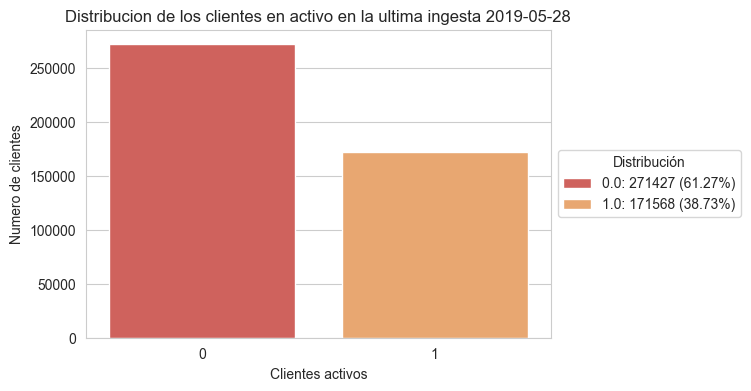

In [85]:
# Contar la distribución de valores en 'active_customer'
count_data = df_filtered_last['active_customer'].value_counts().reset_index()
count_data.columns = ['active_customer', 'count']

# Calcular el porcentaje de cada valor
total_count = count_data['count'].sum()
count_data['percentage'] = (count_data['count'] / total_count) * 100

# Crear el gráfico de barras para la distribución de active_customer
plt.figure(figsize=(6, 4))
barplot = sns.barplot(x='active_customer', y='count', hue='active_customer', data=count_data)

# Añadir etiquetas y título
plt.xlabel('Clientes activos')
plt.ylabel('Numero de clientes')
plt.title('Distribucion de los clientes en activo en la ultima ingesta 2019-05-28')

# Obtener los colores asignados a cada categoría
handles, _ = barplot.get_legend_handles_labels()

# Crear el texto de la leyenda con los números totales y porcentajes
legend_labels = [
    f"{row['active_customer']}: {row['count']:.0f} ({row['percentage']:.2f}%)"
    for _, row in count_data.iterrows()
]

# Añadir la leyenda manualmente con los colores correctos
plt.legend(handles, legend_labels, title='Distribución', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()


Como podemos comprobar en el ultimo mes, tenemos un 61% de clientes inactivos, algo bastante negativo que tendremos en cuenta. A continuacion veremos como se comporta esta variable a lo largo del tiempo y tambien como se comportan los clientes.

In [86]:
# agrupando los clientes por activos y no activos
ca_df.groupby("active_customer")["pk_cid"].nunique()

active_customer
0    317179
1    197731
Name: pk_cid, dtype: int64

In [87]:
ca_df.groupby("active_customer")["pk_cid"].nunique().sum()
# se observa que la cantidad de clientes agrupados por activeCustomer
# es mayor que la cantidad de cliente existente (456373)
# lo que significa que hay clientes que presentan más de un estado

514910

### Descomposición de los clientes según activeCustomer por clientes: siempre activos, nunca activos y con actividad variable.

In [88]:

# Contar cuántos estados diferentes tiene cada cliente en active_customer
estado_por_cliente = ca_df.groupby('pk_cid')['active_customer'].agg(['nunique', 'count'])

# Identificar clientes con estados mixtos (0 y 1)
clientes_mixtos = estado_por_cliente[estado_por_cliente['nunique'] > 1].index

# Excluir los clientes mixtos del análisis de las otras categorías
df_no_mixtos = ca_df[~ca_df['pk_cid'].isin(clientes_mixtos)]

# Identificar clientes que son siempre 0
clientes_siempre_cero = df_no_mixtos.groupby('pk_cid')['active_customer'].min()
clientes_siempre_cero = clientes_siempre_cero[clientes_siempre_cero == 0].index

# Identificar clientes que son siempre 1
clientes_siempre_uno = df_no_mixtos.groupby('pk_cid')['active_customer'].max()
clientes_siempre_uno = clientes_siempre_uno[clientes_siempre_uno == 1].index

# Contar el número de clientes en cada categoría (excluyendo mixtos)
n_siempre_cero = len(clientes_siempre_cero)
n_siempre_uno = len(clientes_siempre_uno)

n_mixtos = len(clientes_mixtos)

# Mostrar los resultados
print(f"Clientes que son siempre 0 en 'active_customer' (excluyendo mixtos): {n_siempre_cero}")
print(f"Clientes que son siempre 1 en 'active_customer' (excluyendo mixtos): {n_siempre_uno}")
print(f"Clientes con estados mixtos (0 y 1): {n_mixtos}")
print(f"Total de clientes en el dataset: {n_siempre_cero + n_siempre_uno + n_mixtos}")


Clientes que son siempre 0 en 'active_customer' (excluyendo mixtos): 258642
Clientes que son siempre 1 en 'active_customer' (excluyendo mixtos): 139194
Clientes con estados mixtos (0 y 1): 58537
Total de clientes en el dataset: 456373


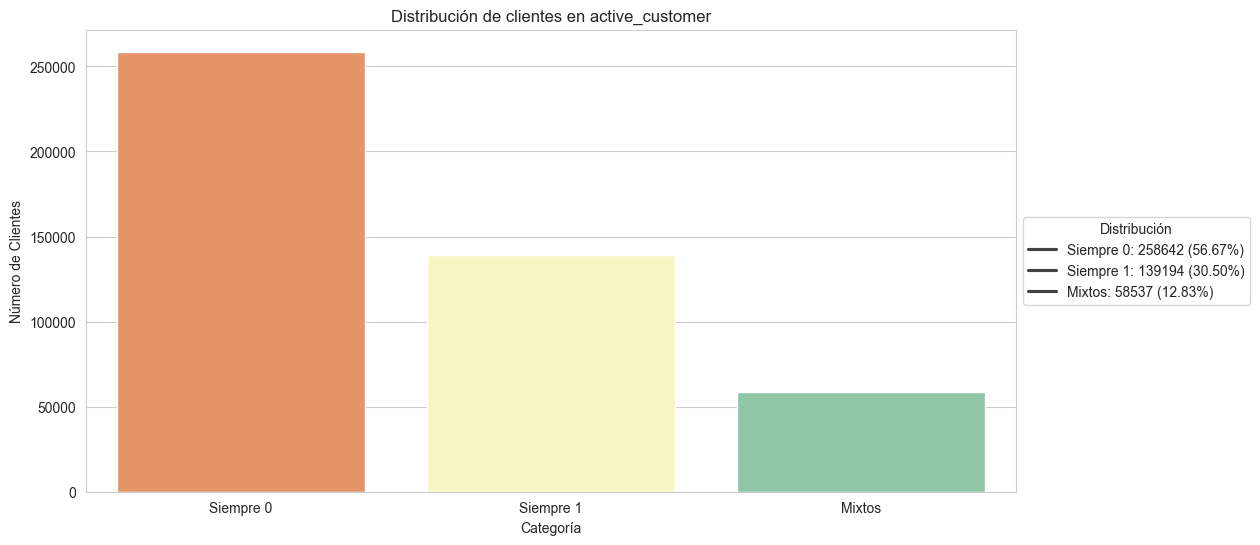

In [89]:

# Definir los datos
labels = ['Siempre 0', 'Siempre 1', 'Mixtos']
valores = [n_siempre_cero, n_siempre_uno, n_mixtos]
total_clientes = sum(valores)
porcentajes = [(v / total_clientes) * 100 for v in valores]

# Crear un DataFrame para seaborn
data = pd.DataFrame({
    'Categoria': labels,
    'Clientes': valores,
    'Porcentaje': porcentajes
})

# Crear el gráfico de barras con seaborn
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Categoria', y='Clientes', data=data, palette="Spectral")

# Añadir títulos y etiquetas
plt.title('Distribución de clientes en active_customer')
plt.ylabel('Número de Clientes')
plt.xlabel('Categoría')

# Crear la leyenda manualmente con los valores y porcentajes
legend_labels2 = [
    f"{row['Categoria']}: {row['Clientes']} ({row['Porcentaje']:.2f}%)"
    for _, row in data.iterrows()
]
# Añadir la leyenda manualmente con los colores correctos
plt.legend(legend_labels2, title='Distribución', loc='center left', bbox_to_anchor=(1, 0.5))
# Mostrar el gráfico
plt.show()



Como podemos ver la mayoria de clientes son fieles a estar o no activos, solo un 12% cambia su estado.

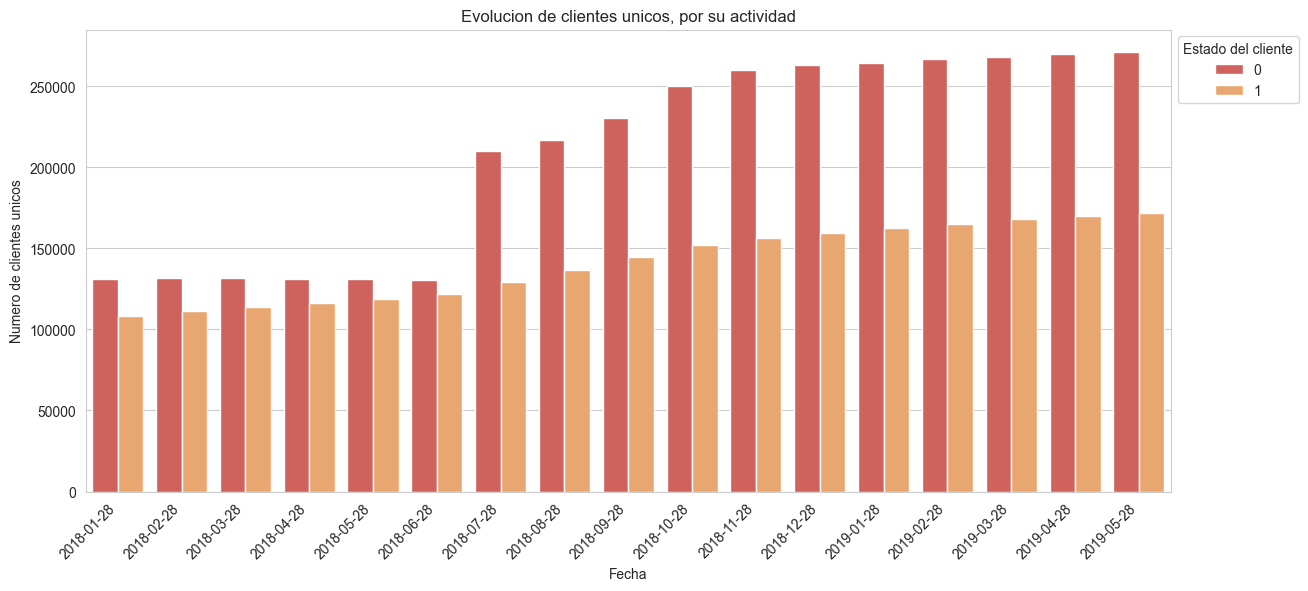

In [90]:
# Agrupar por fecha de ingesta y estado del cliente
df_grouped = ca_df.groupby(['pk_partition', 'active_customer'])['pk_cid'].nunique().reset_index()
df_grouped.columns = ['date', 'active_customer', 'num_customers']

# Crear el gráfico de barras para la evolución de clientes
plt.figure(figsize=(14, 6))
barplot = sns.barplot(x='date', y='num_customers', hue='active_customer', data=df_grouped)

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Numero de clientes unicos')
plt.title('Evolucion de clientes unicos, por su actividad')

# Ajustar el formato de fecha en el eje X
plt.xticks(rotation=45, ha='right')

# Añadir leyenda
plt.legend(title='Estado del cliente', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

Podemos comprobar que el estado del clientes a lo largo del timepo a sido similiar, con un pico de clientes no activos en julio de 2018. El gráfico sugiere que la base de datos de clientes está creciendo con el tiempo, pero una parte significativa de los nuevos clientes no se mantienen activos. Esto podría indicar la necesidad de estrategias para mejorar la retención de clientes o para reactivar a aquellos que se han vuelto inactivos.

## CLIENTES SEGUN ENTRY_CHANNEL

In [91]:
ca_df["entry_channel"] = ca_df["entry_channel"].cat.add_categories(["Unknown"]).fillna("Unknown")
ca_df["entry_channel"].value_counts().head(20).apply(lambda x: x/ca_df["entry_channel"].count()*100)

entry_channel
KHE       52.222
KFC       14.936
KHQ        9.899
KAT        6.978
KHK        3.860
KHM        2.961
Unknown    2.231
KHN        1.818
KFA        1.325
KHD        1.273
RED        1.016
KHL        0.700
KHF        0.346
KHO        0.138
KAZ        0.095
KHC        0.088
KBG        0.028
KEH        0.012
KHP        0.012
007        0.010
Name: count, dtype: float64

In [92]:

# Contar cuántos valores únicos tiene cada cliente en la columna entry_channel
estado_por_cliente_channel = ca_df.groupby('pk_cid')['entry_channel'].agg(['nunique', 'count'])

# Identificar clientes con canales de entrada mixtos (más de un valor en entry_channel)
clientes_mixtos_channel = estado_por_cliente_channel[estado_por_cliente_channel['nunique'] > 1].index

# Excluir los clientes mixtos del análisis de las otras categorías
df_no_mixtos_channel = ca_df[~ca_df['pk_cid'].isin(clientes_mixtos_channel)]

# Identificar clientes que siempre usaron un solo canal de entrada (excluyendo mixtos)
clientes_un_canal = df_no_mixtos_channel.groupby('entry_channel')['pk_cid'].nunique()

# Identificar clientes con valores NaN en entry_channel (excluyendo clientes mixtos)
clientes_con_nan_channel = df_no_mixtos_channel[df_no_mixtos_channel['entry_channel'].isna()]['pk_cid'].unique()

# Contar el número de clientes en cada categoría (excluyendo mixtos)
n_un_canal = clientes_un_canal.sum()
n_con_nan_channel = len(clientes_con_nan_channel)
n_mixtos_channel = len(clientes_mixtos_channel)

# Mostrar los resultados
print(f"Clientes que siempre usaron un solo canal de entrada (excluyendo mixtos): {n_un_canal}")
print(f"Clientes con valores NaN en 'entry_channel' (excluyendo mixtos): {n_con_nan_channel}")
print(f"Clientes con canales de entrada mixtos: {n_mixtos_channel}")

Clientes que siempre usaron un solo canal de entrada (excluyendo mixtos): 331869
Clientes con valores NaN en 'entry_channel' (excluyendo mixtos): 0
Clientes con canales de entrada mixtos: 124504


El 27% de los clientes presentan canales de entradas mixtos o bien no se conocen y con la entrada de nuevos registros se fueron actualizando o por algun error se registran inicialmente con una entrada pero luego se actualizan.

Así que para mantener una adecuada consistencia en los datos se trabajará con la información más reciente, es decir, se reemplazará los clientes con valores diferentes por la última entrada para simplificar análisis posteriores y evitar confusión.

In [93]:
# Paso 1: Identificar clientes con canales de entrada mixtos
estado_por_cliente_channel = ca_df.groupby('pk_cid')['entry_channel'].agg(['nunique', 'count'])
clientes_mixtos_channel = estado_por_cliente_channel[estado_por_cliente_channel['nunique'] > 1].index

# Paso 2: Filtrar solo los registros con clientes mixtos
df_mixtos = ca_df[ca_df['pk_cid'].isin(clientes_mixtos_channel)].copy()

# Paso 3: Ordenar df_mixtos por pk_partition para asegurar que la última partición sea la que se use
df_mixtos = df_mixtos.sort_values(by=['pk_cid', 'pk_partition'])

# Paso 4: Reemplazar "Unknown" con el valor no "Unknown" más reciente o mantener el valor de la última partición
df_mixtos['nuevo_canal'] = df_mixtos.groupby('pk_cid')['entry_channel'].transform(
    lambda x: x.replace("Unknown", x[x != "Unknown"].iloc[-1]) if "Unknown" in x.values and x.nunique() > 1 else x.iloc[-1]
)

# Paso 5: Actualizar la columna original en ca_df con el valor de la última partición
ca_df.loc[ca_df['pk_cid'].isin(clientes_mixtos_channel), 'entry_channel'] = df_mixtos['nuevo_canal']


Se vuelve a comprobar lo anterior:

In [94]:
# Contar cuántos valores únicos tiene cada cliente en la columna entry_channel
estado_por_cliente_channel = ca_df.groupby('pk_cid')['entry_channel'].agg(['nunique', 'count'])

# Identificar clientes con canales de entrada mixtos (más de un valor en entry_channel)
clientes_mixtos_channel = estado_por_cliente_channel[estado_por_cliente_channel['nunique'] > 1].index

# Excluir los clientes mixtos del análisis de las otras categorías
df_no_mixtos_channel = ca_df[~ca_df['pk_cid'].isin(clientes_mixtos_channel)]

# Identificar clientes que siempre usaron un solo canal de entrada (excluyendo mixtos)
clientes_un_canal = df_no_mixtos_channel.groupby('entry_channel')['pk_cid'].nunique()

# Identificar clientes con valores NaN en entry_channel (excluyendo clientes mixtos)
clientes_con_nan_channel = df_no_mixtos_channel[df_no_mixtos_channel['entry_channel'].isna()]['pk_cid'].unique()

# Contar el número de clientes en cada categoría (excluyendo mixtos)
n_un_canal = clientes_un_canal.sum()
n_con_nan_channel = len(clientes_con_nan_channel)
n_mixtos_channel = len(clientes_mixtos_channel)

# Mostrar los resultados
print(f"Clientes que siempre usaron un solo canal de entrada (excluyendo mixtos): {n_un_canal}")
print(f"Clientes con valores NaN en 'entry_channel' (excluyendo mixtos): {n_con_nan_channel}")
print(f"Clientes con canales de entrada mixtos: {n_mixtos_channel}")

Clientes que siempre usaron un solo canal de entrada (excluyendo mixtos): 454709
Clientes con valores NaN en 'entry_channel' (excluyendo mixtos): 0
Clientes con canales de entrada mixtos: 1664


Se comprueba que ya no existen valores mixtos, lo que significa que cada cliente tiene su propio entry_channel

Existen muchos canales de captación de clientes siendo los principales KHE, KFC, KHQ, KAT   



In [95]:
ca_df["entry_channel"].value_counts().head(15).apply(lambda x: x/ca_df["entry_channel"].count()*100)

entry_channel
KHE       52.197
KFC       14.924
KHQ       11.182
KAT        6.980
KHK        3.851
KHM        3.434
KHN        2.061
KFA        1.328
KHD        1.272
RED        1.120
KHL        0.697
KHF        0.345
KHO        0.157
Unknown    0.157
KAZ        0.094
Name: count, dtype: float64

Como hay muchos canales por debajo del 1% se decide agruparlos en una única categoría llamada Otros

In [96]:
# Obtener las 10 categorías más frecuentes
top_10 = ca_df["entry_channel"].value_counts().nlargest(10).index
# Reemplazar las categorías que no están en el top 10 por "Otros"
ca_df["entry_channel"] = ca_df["entry_channel"].apply(lambda x: x if x in top_10 else "Otros")
# Verificar el resultado
print(ca_df["entry_channel"].value_counts())

entry_channel
KHE      3112494
KFC       889894
KHQ       666795
KAT       416216
KHK       229634
KHM       204737
KHN       122896
Otros      98487
KFA        79164
KHD        75826
RED        66781
Name: count, dtype: int64


Gráfico final de entry_channel

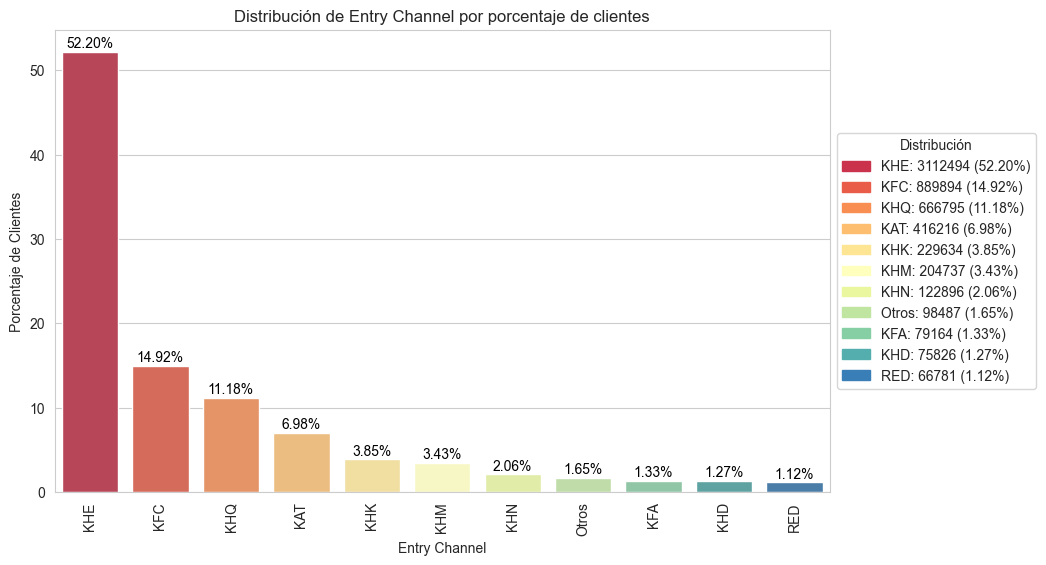

In [97]:
# Calcular las frecuencias y porcentajes para 'entry_channel'
channel_counts = ca_df['entry_channel'].value_counts().reset_index()
channel_counts.columns = ['entry_channel', 'count']
total_count = channel_counts['count'].sum()
channel_counts['percentage'] = (channel_counts['count'] / total_count) * 100

# Crear el gráfico de barras con seaborn y la paleta de colores 'Spectral'
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='entry_channel', y='percentage', data=channel_counts, palette='Spectral')

# Añadir etiquetas con los porcentajes encima de cada barra
for index, row in channel_counts.iterrows():
    barplot.text(index, row['percentage'] + 0.5, f"{row['percentage']:.2f}%", color='black', ha="center")

# Añadir títulos y etiquetas
plt.xlabel('Entry Channel')
plt.ylabel('Porcentaje de Clientes')
plt.title('Distribución de Entry Channel por porcentaje de clientes')

# Crear la leyenda manualmente con los valores y porcentajes
handles = [plt.Rectangle((0, 0), 1, 1, color=sns.color_palette('Spectral', n_colors=len(channel_counts))[i]) 
        for i in range(len(channel_counts))]
labels = [f"{row['entry_channel']}: {row['count']} ({row['percentage']:.2f}%)" 
        for _, row in channel_counts.iterrows()]

# Añadir la leyenda con porcentajes y valores
plt.legend(handles, labels, title='Distribución', loc='center left', bbox_to_anchor=(1, 0.5))

# Rotar las etiquetas del eje x si es necesario
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.show()


## CLIENTES SEGUN ENTRY DATE

Analisis de la fechas de contratacion por cliente

In [98]:
# Contar cuántos valores únicos de 'entry_date' tiene cada cliente
estado_por_cliente_fecha = ca_df.groupby('pk_cid')['entry_date'].nunique()

# Identificar clientes con fechas de registro mixtas (múltiples fechas de registro)
clientes_mixtos_fecha = estado_por_cliente_fecha[estado_por_cliente_fecha > 1].index

# Excluir los clientes mixtos del análisis de las otras categorías
df_no_mixtos_fecha = ca_df[~ca_df['pk_cid'].isin(clientes_mixtos_fecha)]

# Identificar clientes que tienen siempre la misma fecha de registro
clientes_misma_fecha = df_no_mixtos_fecha.groupby('pk_cid')['entry_date'].nunique()
clientes_misma_fecha = clientes_misma_fecha[clientes_misma_fecha == 1].index

# Identificar clientes con valores NaN en 'entry_date' (excluyendo clientes mixtos)
clientes_con_nan_fecha = df_no_mixtos_fecha[df_no_mixtos_fecha['entry_date'].isna()]['pk_cid'].unique()

# Contar el número de clientes en cada categoría (excluyendo mixtos)
n_misma_fecha = len(clientes_misma_fecha)
n_con_nan_fecha = len(clientes_con_nan_fecha)
n_mixtos_fecha = len(clientes_mixtos_fecha)

# Mostrar los resultados
print(f"Clientes que tienen siempre la misma fecha de registro: {n_misma_fecha}")
print(f"Clientes con todos los valores NaN en 'entry_date' en todas las particiones: {n_con_nan_fecha}")
print(f"Clientes con fechas de registro mixtas (diferentes fechas): {n_mixtos_fecha}")

Clientes que tienen siempre la misma fecha de registro: 456366
Clientes con todos los valores NaN en 'entry_date' en todas las particiones: 0
Clientes con fechas de registro mixtas (diferentes fechas): 7


Al revisar los datos, se detectaron inconsistencias en la columna entry_date para ciertos clientes, donde la fecha de registro variaba entre diferentes particiones de datos. Dado que la entry_date debe representar un evento único en el tiempo, cualquier variabilidad en esta columna es indicativa de un posible error de datos. Esto podría haber sido causado por errores en la carga de datos, actualizaciones incorrectas, o fallos en la sincronización de bases de datos. Para garantizar la calidad y consistencia de los datos, se ha decidido corregir la entry_date al valor más temprano registrado para cada cliente, ya que este valor refleja con mayor precisión el verdadero momento de registro del cliente.

Rellenar con la Fecha Anterior (Forward Fill) que los valores NaT se rellenen con la última fecha conocida (hacia adelante) ya que se supone que los clientes mantuvieron la misma fecha de registro hasta que haya un nuevo valor disponible.

In [99]:
# Corrigiendo valores nulos en la columna 'entry_date' con Forward Fill
ca_df['entry_date'] = ca_df['entry_date'].fillna(method='ffill')

Al ejecutar este código, todos los valores de entry_date para un pk_cid específico se reemplazarán por la primera fecha que aparece para ese cliente en la partición con la pk_partition más baja. Esto garantiza que el entry_date sea consistente y se base en el primer registro disponible para cada cliente.

In [100]:
# Corregiendo los registros mixtos en 'entry_date' con la fecha de la primera partición
ca_df = ca_df.sort_values(by=['pk_cid', 'pk_partition'])
# Obtener el primer entry_date para cada pk_cid
first_entry_dates = ca_df.groupby('pk_cid')['entry_date'].first()

# Aplicar el primer entry_date a todas las filas del mismo pk_cid
ca_df['entry_date'] = ca_df['pk_cid'].map(first_entry_dates)

Comprobación de los reemplazos de los valores nulos y mixtos en el dataset

In [101]:
# Contar cuántos valores únicos de 'entry_date' tiene cada cliente
estado_por_cliente_fecha = ca_df.groupby('pk_cid')['entry_date'].nunique()

# Identificar clientes con fechas de registro mixtas (múltiples fechas de registro)
clientes_mixtos_fecha = estado_por_cliente_fecha[estado_por_cliente_fecha > 1].index

# Excluir los clientes mixtos del análisis de las otras categorías
df_no_mixtos_fecha = ca_df[~ca_df['pk_cid'].isin(clientes_mixtos_fecha)]

# Identificar clientes que tienen siempre la misma fecha de registro
clientes_misma_fecha = df_no_mixtos_fecha.groupby('pk_cid')['entry_date'].nunique()
clientes_misma_fecha = clientes_misma_fecha[clientes_misma_fecha == 1].index

# Identificar clientes con valores NaN en 'entry_date' (excluyendo clientes mixtos)
clientes_con_nan_fecha = df_no_mixtos_fecha[df_no_mixtos_fecha['entry_date'].isna()]['pk_cid'].unique()

# Contar el número de clientes en cada categoría (excluyendo mixtos)
n_misma_fecha = len(clientes_misma_fecha)
n_con_nan_fecha = len(clientes_con_nan_fecha)
n_mixtos_fecha = len(clientes_mixtos_fecha)

# Mostrar los resultados
print(f"Clientes que tienen siempre la misma fecha de registro: {n_misma_fecha}")
print(f"Clientes con todos los valores NaN en 'entry_date' en todas las particiones: {n_con_nan_fecha}")
print(f"Clientes con fechas de registro mixtas (diferentes fechas): {n_mixtos_fecha}")

Clientes que tienen siempre la misma fecha de registro: 456373
Clientes con todos los valores NaN en 'entry_date' en todas las particiones: 0
Clientes con fechas de registro mixtas (diferentes fechas): 0


Última comprobación para ver si existen fechas anómalas

In [102]:
ca_df["entry_date"].min(), ca_df["entry_date"].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-05-31 00:00:00'))

In [103]:
# Definir el rango completo de fechas válidas dentro del rango temporal
start_date = '2015-01-01'
end_date = '2019-05-31'
valid_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# Supongamos que 'serie_temporal' es tu serie temporal con fechas
invalid_dates = ca_df["entry_date"][~ca_df["entry_date"].isin(valid_dates)]

# Mostrar las fechas inválidas encontradas
print("Fechas inválidas detectadas:")
print(invalid_dates)

Fechas inválidas detectadas:
Series([], Name: entry_date, dtype: datetime64[ns])


### Comportamiento de los clientes según la fecha en que se realizó la primera contratación

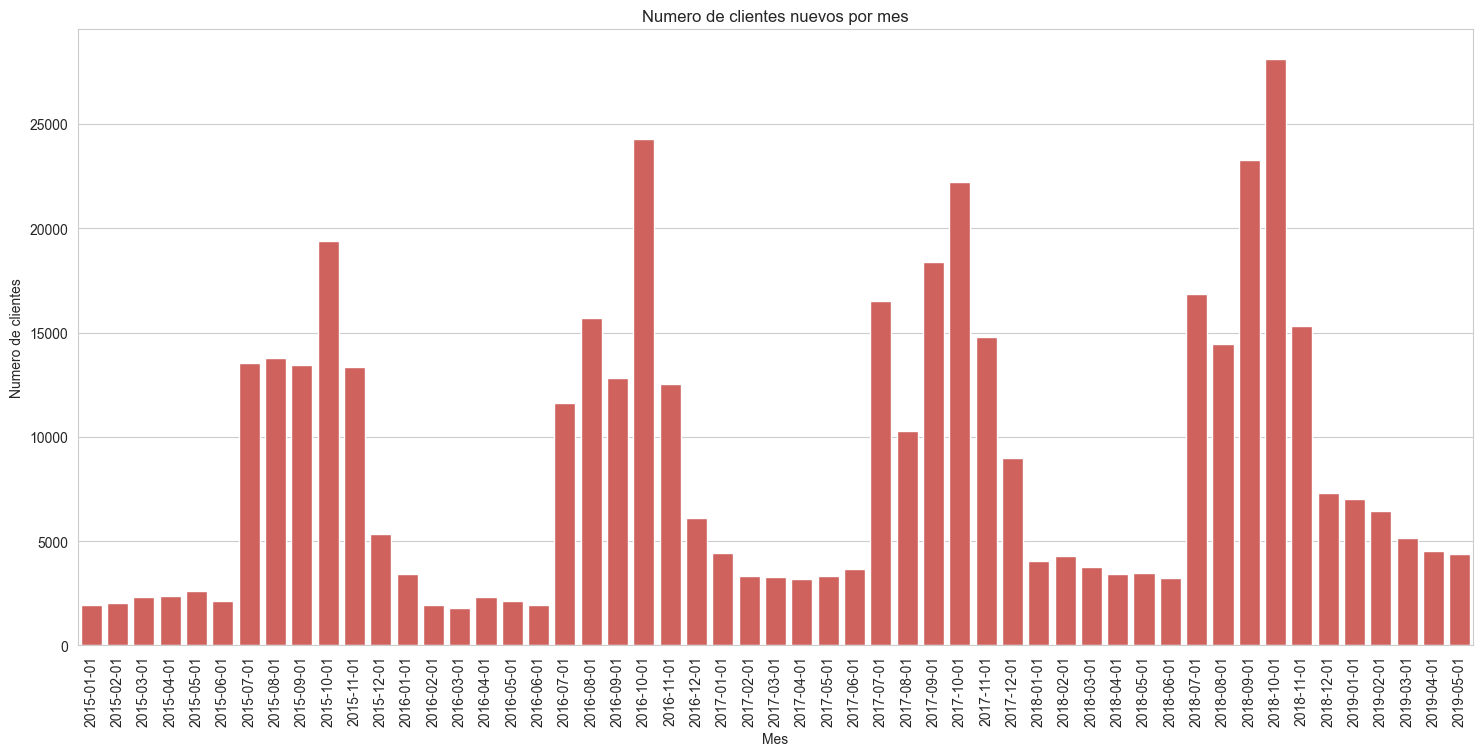

In [111]:

# Crear un dataframe con los clientes que tienen siempre la misma fecha de registro
misma_fecha_clientes = ca_df[ca_df['pk_cid'].isin(clientes_misma_fecha)]

# Convertir 'entry_date' a datetime si no lo está
misma_fecha_clientes['entry_date'] = pd.to_datetime(misma_fecha_clientes['entry_date'])

# Agrupar por mes y contar la cantidad de clientes únicos en cada mes
monthly_customers = misma_fecha_clientes.groupby(misma_fecha_clientes['entry_date'].dt.to_period('M'))['pk_cid'].nunique().reset_index()

# Renombrar las columnas
monthly_customers.columns = ['entry_month', 'num_customers']

# Convertir 'entry_month' de Period a Timestamp para facilitar el trazado
monthly_customers['entry_month'] = monthly_customers['entry_month'].dt.to_timestamp()

# Crear el gráfico de líneas con seaborn
plt.figure(figsize=(18, 8))
sns.barplot(x='entry_month', y='num_customers', data=monthly_customers)

# Añadir títulos y etiquetas
plt.title('Numero de clientes nuevos por mes')
plt.xlabel('Mes')
plt.ylabel('Numero de clientes')
plt.xticks(rotation=90)
# Mostrar el gráfico
plt.show()


El gráfico muestra que hay ciclos claros en la actividad de adquisición de clientes, con picos notables que podrían estar vinculados a eventos específicos, y una estabilización hacia el final del periodo. Analizar más a fondo las causas de estos picos podría proporcionar insights valiosos para futuras estrategias de crecimiento.

Los períodos principales son: Mediados de Julio hasta mediados de Agosto y desde Septiembre hasta mediados de Agosto y también a inicios de Enero, para cada año.

## SEGMENTACIÓN DE CLIENTES

Analizando de forma general el comportamiento de la segmentacion de los clientes

In [112]:
# Reemplazar valores nulos en la columna 'segment' por 'Unknown'
ca_df["segment"] = ca_df["segment"].cat.add_categories(["Unknown"]).fillna("Unknown")

# Contar cuántos valores únicos de 'segment' tiene cada cliente
estado_por_cliente_segment = ca_df.groupby('pk_cid')['segment'].nunique()

# Identificar clientes con segmentos mixtos (más de un segmento diferente)
clientes_mixtos_segment = estado_por_cliente_segment[estado_por_cliente_segment > 1].index

# Identificar clientes que tienen siempre el mismo segmento
clientes_mismo_segment = estado_por_cliente_segment[estado_por_cliente_segment == 1].index

# Filtrar DataFrames con clientes con segmentos mixtos y con el mismo segmento
df_mixtos_segment = ca_df[ca_df['pk_cid'].isin(clientes_mixtos_segment)]
df_mismo_segment = ca_df[ca_df['pk_cid'].isin(clientes_mismo_segment)]

# Mostrar los resultados
print(f"Clientes que tienen siempre el mismo 'segment': {len(clientes_mismo_segment)}")
print(f"Clientes con segmentos mixtos (diferentes segmentos): {len(clientes_mixtos_segment)}")

Clientes que tienen siempre el mismo 'segment': 326078
Clientes con segmentos mixtos (diferentes segmentos): 130295


In [113]:
df_mixtos_segment

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
1479563,15891,2018-07-28,2018-07-28,KAT,1,Unknown
2168122,15891,2018-08-28,2018-07-28,KAT,0,02 - PARTICULARES
2962973,16063,2018-11-28,2018-11-19,KAT,1,Unknown
3628236,16063,2018-12-28,2018-11-19,KAT,1,02 - PARTICULARES
4028169,16063,2019-01-28,2018-11-19,KAT,1,02 - PARTICULARES
...,...,...,...,...,...,...
5682990,1548204,2019-05-28,2019-04-29,KHN,0,02 - PARTICULARES
5100677,1548206,2019-04-28,2019-04-29,KHM,0,Unknown
5682989,1548206,2019-05-28,2019-04-29,KHM,0,02 - PARTICULARES
5100678,1548207,2019-04-28,2019-04-29,KHN,0,Unknown


In [114]:
# Crear una función para reemplazar 'Unknown' con el valor válido en 'segment'
def reemplazar_segment(grupo):
    if 'Unknown' in grupo.values:
        # Encuentra el valor que no es 'Unknown'
        valor_no_unknown = grupo[grupo != 'Unknown'].unique()
        if len(valor_no_unknown) > 0:
            return grupo.replace('Unknown', valor_no_unknown[0])
    return grupo

# Aplicar la función a cada grupo de 'pk_cid'
df_mixtos_segment['segment'] = df_mixtos_segment.groupby('pk_cid')['segment'].transform(reemplazar_segment)

In [115]:
# Contar cuántos valores únicos de 'segment' tiene cada cliente
estado_por_cliente_segment = ca_df.groupby('pk_cid')['segment'].nunique()

# Identificar clientes con segmentos mixtos (más de un segmento diferente)
clientes_mixtos_segment = estado_por_cliente_segment[estado_por_cliente_segment > 1].index

# Identificar clientes que tienen siempre el mismo segmento
clientes_mismo_segment = estado_por_cliente_segment[estado_por_cliente_segment == 1].index

# Filtrar DataFrames con clientes con segmentos mixtos y con el mismo segmento
df_mixtos_segment = ca_df[ca_df['pk_cid'].isin(clientes_mixtos_segment)]
df_mismo_segment = ca_df[ca_df['pk_cid'].isin(clientes_mismo_segment)]

# Mostrar los resultados
print(f"Clientes que tienen siempre el mismo 'segment': {len(clientes_mismo_segment)}")
print(f"Clientes con segmentos mixtos (diferentes segmentos): {len(clientes_mixtos_segment)}")

Clientes que tienen siempre el mismo 'segment': 326078
Clientes con segmentos mixtos (diferentes segmentos): 130295


2.78% de los clientes tienen segmentos mixtos, es decir, presentan más de un segmento en el tiempo
o bien sean porque se han cambiado de segmento ya que antes eran universitarios y ahora son particulares o top
y viceversa o bien porque se han reflejado mal los datos o se han actualizado
en cualquier caso, se procede a corregir los segmentos mixtos con el segmento más reciente

In [116]:
# Ordenar los datos por 'pk_cid' y 'pk_partition' para asegurarse del orden cronológico
ca_df = ca_df.sort_values(by=['pk_cid', 'pk_partition'])

# Reemplazar 'segment' con el último valor disponible para cada 'pk_cid'
ca_df['segment'] = ca_df.groupby('pk_cid')['segment'].transform('last')

Volviendo a comprobar:

In [117]:
estado_por_cliente_segment = ca_df.groupby('pk_cid')['segment'].nunique()

# Identificar clientes con segmentos mixtos (más de un segmento diferente)
clientes_mixtos_segment = estado_por_cliente_segment[estado_por_cliente_segment > 1].index

# Identificar clientes que tienen siempre el mismo segmento
clientes_mismo_segment = estado_por_cliente_segment[estado_por_cliente_segment == 1].index

# Filtrar DataFrames con clientes con segmentos mixtos y con el mismo segmento
df_mixtos_segment = ca_df[ca_df['pk_cid'].isin(clientes_mixtos_segment)]
df_mismo_segment = ca_df[ca_df['pk_cid'].isin(clientes_mismo_segment)]

# Mostrar los resultados
print(f"Clientes que tienen siempre el mismo 'segment': {len(clientes_mismo_segment)}")
print(f"Clientes con segmentos mixtos (diferentes segmentos): {len(clientes_mixtos_segment)}")

Clientes que tienen siempre el mismo 'segment': 456373
Clientes con segmentos mixtos (diferentes segmentos): 0


Por otra parte, los clientes que no se conece su segmento que representan el 0,15% del total de clientes, 
se les asignará el segmento más común que en este caso es 03 - UNIVERSITARIO

In [118]:
ca_df["segment"].value_counts()

segment
03 - UNIVERSITARIO    3975678
02 - PARTICULARES     1882315
01 - TOP                93856
Unknown                 11075
Name: count, dtype: int64

In [119]:
# Reemplazar 'Unknown' con '03 - UNIVERSITARIO'
ca_df["segment"] = ca_df["segment"].replace({"Unknown": "03 - UNIVERSITARIO"})
# Verificar el resultado final
ca_df["segment"].value_counts()

segment
03 - UNIVERSITARIO    3986753
02 - PARTICULARES     1882315
01 - TOP                93856
Name: count, dtype: int64

In [120]:
# Contar cuántos valores únicos de 'segment' tiene cada cliente
ca_df.groupby("segment")["pk_cid"].nunique()

segment
01 - TOP                7556
02 - PARTICULARES     152299
03 - UNIVERSITARIO    296518
Name: pk_cid, dtype: int64

In [121]:
# comprobando el total de clientes en el dataset
7620 + 152421 + 296332

456373

### Distribución de clientes según segment

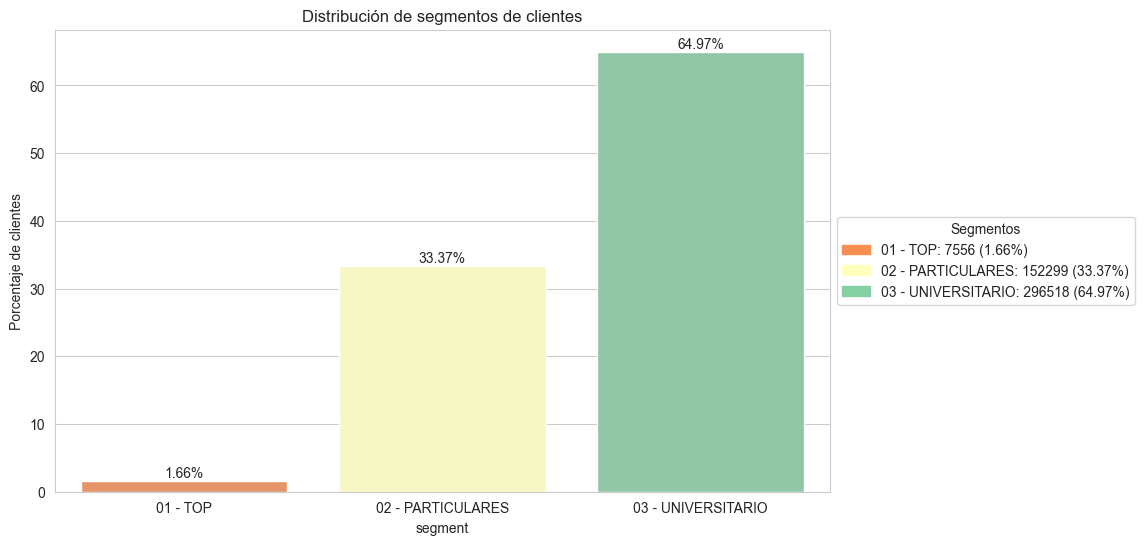

In [134]:
# Agrupar por segmento, contar clientes únicos y calcular el porcentaje
segment_distribution = ca_df.groupby("segment")["pk_cid"].nunique().reset_index()
total_customers = ca_df["pk_cid"].nunique()
segment_distribution.columns = ['segment', 'num_customers']
segment_distribution['percentage'] = (segment_distribution['num_customers'] / total_customers) * 100

# Crear el gráfico de barras con seaborn
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='segment', y='percentage', data=segment_distribution, palette='Spectral')

# Añadir los porcentajes encima de las barras
for index, row in segment_distribution.iterrows():
    barplot.text(index, row['percentage'] + 0.5, f"{row['percentage']:.2f}%", ha='center')

# Añadir títulos y etiquetas
plt.title('Distribución de segmentos de clientes')
plt.ylabel('Porcentaje de clientes')

# Crear la leyenda con los colores correspondientes, el número total de clientes y los porcentajes
handles = [plt.Rectangle((0, 0), 1, 1, color=sns.color_palette('Spectral', n_colors=len(segment_distribution))[i]) 
        for i in range(len(segment_distribution))]
# Etiquetas con el nombre del segmento, número total de clientes y porcentaje
labels = [f"{row['segment']}: {row['num_customers']} ({row['percentage']:.2f}%)" 
        for _, row in segment_distribution.iterrows()]

# Añadir la leyenda al gráfico
plt.legend(handles, labels, title='Segmentos', loc='center left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.show()



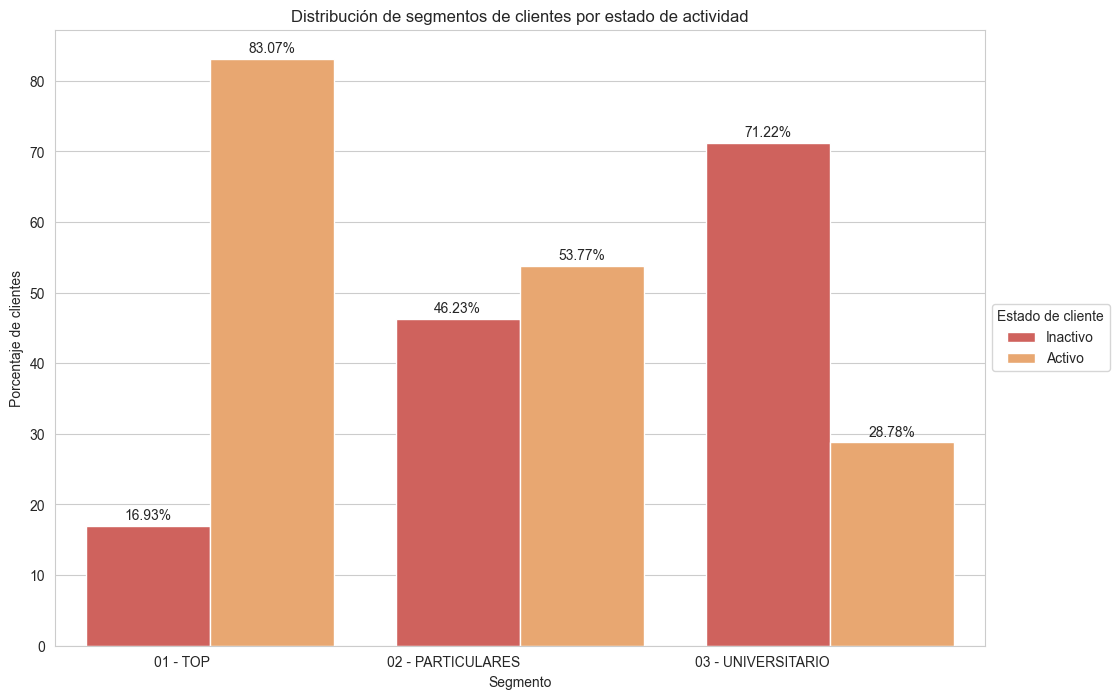

In [132]:
# Crear el dataframe con los clientes activos e inactivos por segmento
segment_distribution = ca_df.groupby(['segment', 'active_customer'])['pk_cid'].nunique().reset_index()
total_customers = ca_df['pk_cid'].nunique()

# Calcular el porcentaje dentro de cada segmento por estado de cliente activo
segment_distribution['percentage'] = segment_distribution.groupby('segment')['pk_cid'].transform(lambda x: (x / x.sum()) * 100)

# Crear el gráfico de barras con seaborn
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='segment', y='percentage', hue='active_customer', data=segment_distribution)

# Añadir etiquetas con los porcentajes encima de las barras
for container in barplot.containers:
    for bar in container:
        height = bar.get_height()
        barplot.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f'{height:.2f}%',
            ha='center',
            va='bottom'
        )

# Añadir títulos y etiquetas
plt.title('Distribución de segmentos de clientes por estado de actividad')
plt.xlabel('Segmento')
plt.ylabel('Porcentaje de clientes')

# Obtener la leyenda actual y ajustar etiquetas
handles, labels = barplot.get_legend_handles_labels()
new_labels = []

# Crear etiquetas para la leyenda
for label in labels:
    active = int(label)  # Convert label to integer to match active_customer values
    num_customers = segment_distribution[segment_distribution['active_customer'] == active]['pk_cid'].sum()
    percentage = segment_distribution[segment_distribution['active_customer'] == active]['percentage'].sum()
    status = "Activo" if active == 1 else "Inactivo"
    new_labels.append(f"{status}")

# Añadir la leyenda al gráfico
plt.legend(handles=handles, labels=new_labels, title='Estado de cliente', loc='center left', bbox_to_anchor=(1, 0.5))

# Rotar las etiquetas del eje X para mayor claridad
plt.xticks(ha='right')

# Mostrar el gráfico
plt.show()


Despues de ver la distribucion de segment, llego  al conclusion, que la mayoria que tenemos son clientes universatirios y que son los clientes con menos actividad en proporcion a los otros segmentos, los clientes TOP son los clientes mas activos y los particulares estan mas equilibrados. Aun asi esta segmentacion es bastante basica y no tengo claro como se hizo. Uno de mis siguientes pasos sera hacer una nueva segmentacion con mas sentido, explicabilidad y mas grupos.

## CLIENTES POR PK_PARTITION

Identificación de clientes que solo están presentes en una partición y los que están presentes en más de una

In [135]:
# Contar cuántos valores únicos de 'pk_partition' tiene cada cliente
estado_por_cliente_partition = ca_df.groupby('pk_cid')['pk_partition'].nunique()

# Identificar clientes con particiones mixtas (múltiples particiones)
clientes_mixtos_partition = estado_por_cliente_partition[estado_por_cliente_partition > 1].index

# Excluir los clientes mixtos del análisis de las otras categorías
df_no_mixtos_partition = ca_df[~ca_df['pk_cid'].isin(clientes_mixtos_partition)]

# Identificar clientes que están asociados a una única partición
clientes_una_particion = df_no_mixtos_partition.groupby('pk_cid')['pk_partition'].nunique()
clientes_una_particion = clientes_una_particion[clientes_una_particion == 1].index

# Identificar clientes con valores NaN en 'pk_partition' (excluyendo clientes mixtos)
clientes_con_nan_partition = df_no_mixtos_partition[df_no_mixtos_partition['pk_partition'].isna()]['pk_cid'].unique()

# Contar el número de clientes en cada categoría (excluyendo mixtos)
n_una_particion = len(clientes_una_particion)
n_con_nan_partition = len(clientes_con_nan_partition)
n_mixtos_partition = len(clientes_mixtos_partition)

# Mostrar los resultados
print(f"Clientes que están asociados a una única partición, que no se repiten más de una vez: {n_una_particion}")
print(f"Clientes con valores NaN en 'pk_partition': {n_con_nan_partition}")
print(f"Clientes que se repiten en al menos 2 particiones: {n_mixtos_partition}")

Clientes que están asociados a una única partición, que no se repiten más de una vez: 8814
Clientes con valores NaN en 'pk_partition': 0
Clientes que se repiten en al menos 2 particiones: 447559


### ANALISIS PARA LA IDENTIFICACION DE CLIENTES NUEVOS EN CADA PARTICION CON RESPECTO A LA ANTERIOR

In [40]:
# Ordenar los datos por 'pk_partition' y 'pk_cid'
ca_df = ca_df.sort_values(by=['pk_partition', 'pk_cid'])

# Obtener una lista única de particiones ordenadas
particiones = ca_df['pk_partition'].unique()

# Crear un diccionario para almacenar el número de clientes en la primera partición y los nuevos clientes por cada partición
clientes_por_particion = {}

# Mantener un conjunto de todos los clientes vistos hasta la partición actual
clientes_acumulados = set()

# Iterar sobre las particiones
for particion in particiones:
    # Obtener los clientes de la partición actual
    clientes_actuales = set(ca_df[ca_df['pk_partition'] == particion]['pk_cid'])
    
    # Identificar nuevos clientes en la partición actual excluyendo los ya vistos
    nuevos_en_particion_actual = clientes_actuales - clientes_acumulados
    
    # Almacenar el número de nuevos clientes en el diccionario
    clientes_por_particion[particion] = len(nuevos_en_particion_actual)
    
    # Actualizar el conjunto acumulado con los clientes actuales
    clientes_acumulados.update(clientes_actuales)

# Convertir el diccionario en un DataFrame para su análisis
df_clientes_por_particion = pd.DataFrame(list(clientes_por_particion.items()), columns=['pk_partition', 'num_clientes'])

# Mostrar los resultados
print(df_clientes_por_particion)

   pk_partition  num_clientes
0    2018-01-28        239493
1    2018-02-28          3767
2    2018-03-28          3411
3    2018-04-28          2952
4    2018-05-28          3031
5    2018-06-28          2845
6    2018-07-28         83840
7    2018-08-28         14596
8    2018-09-28         23353
9    2018-10-28         28205
10   2018-11-28         15557
11   2018-12-28          7402
12   2019-01-28          6926
13   2019-02-28          6193
14   2019-03-28          5690
15   2019-04-28          4581
16   2019-05-28          4531


In [41]:
# comprobando que la suma de los clientes por particion sea igual a la cantidad de clientes unicos
df_clientes_por_particion["num_clientes"].sum()

456373

#### Clientes nuevos en cada partición

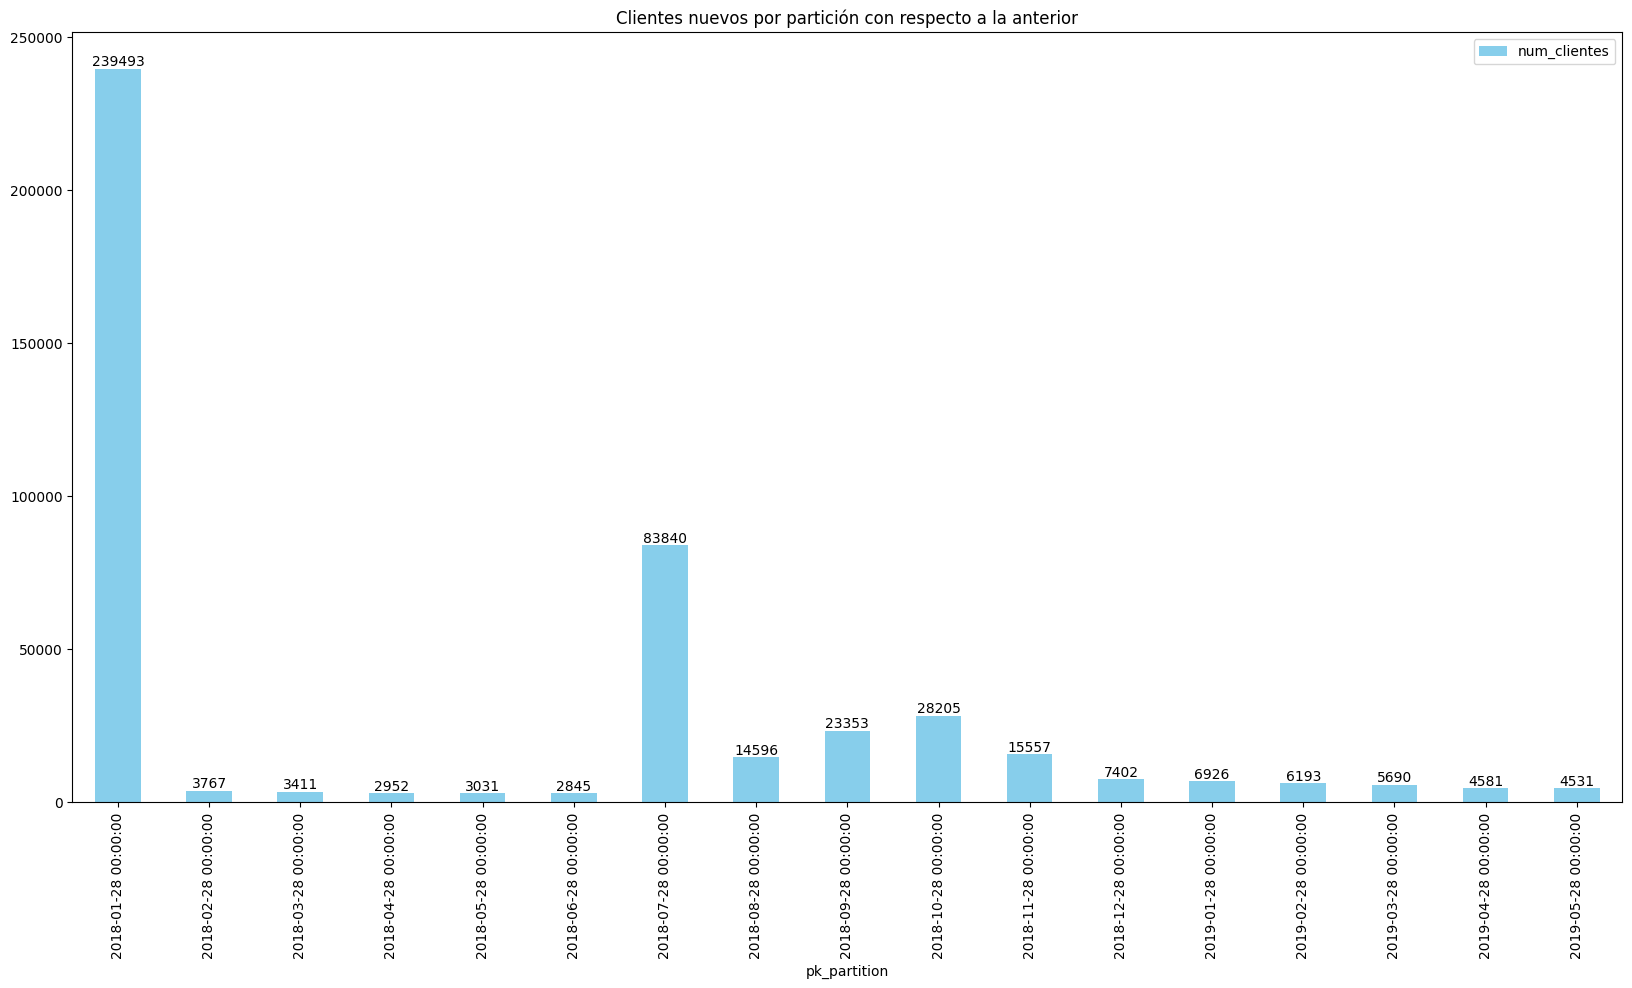

In [42]:
df_clientes_por_particion.plot(kind='bar', x='pk_partition', y='num_clientes', figsize=(20, 10), color='skyblue', title='Clientes nuevos por partición con respecto a la anterior')  
for i in range(len(df_clientes_por_particion)):
    plt.text(i, df_clientes_por_particion['num_clientes'][i], df_clientes_por_particion['num_clientes'][i], ha = 'center', va = 'bottom')
plt.show()

El gráfico muestra algunos picos eventuales que podrían estar asociados a campañas o eventos específicos. Hacia el final del período, se observa una tendencia a la baja en la adquisición de nuevos clientes, lo que podría sugerir la necesidad de nuevas estrategias para atraer clientes o un mercado más maduro.

## Distribución de clientes según antiguedad

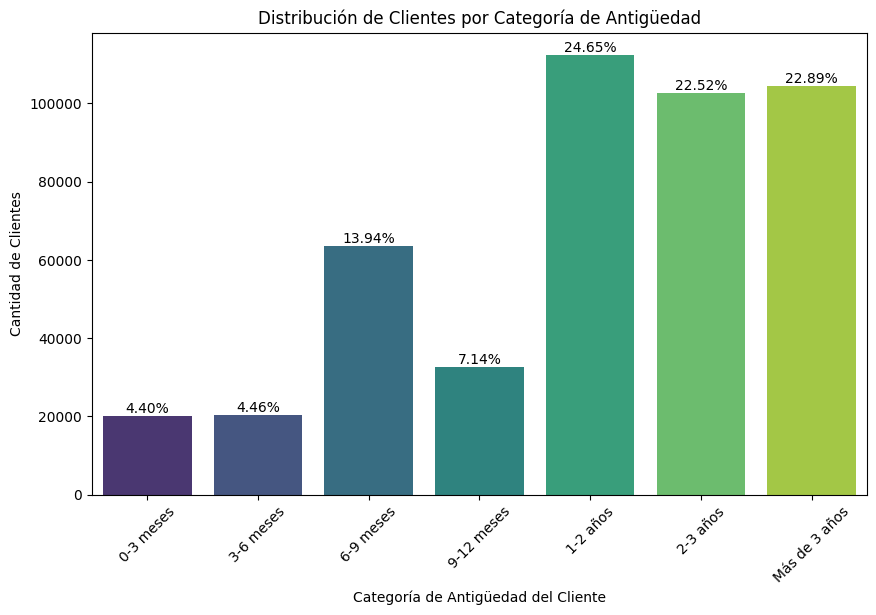

In [43]:
# Asegúrate de que 'entry_date' y 'pk_partition' estén en formato de fecha
ca_df['entry_date'] = pd.to_datetime(ca_df['entry_date'])
ca_df['pk_partition'] = pd.to_datetime(ca_df['pk_partition'])

# Obtener el último pk_partition por cliente
ultima_fecha_por_cliente = ca_df.groupby('pk_cid')['pk_partition'].max().reset_index()
ultima_fecha_por_cliente.rename(columns={'pk_partition': 'ultima_fecha'}, inplace=True)

# Fusionar con el DataFrame original para tener 'entry_date' y 'ultima_fecha'
df_full_clean = ca_df.merge(ultima_fecha_por_cliente, on='pk_cid', how='left')

# Calcular la antigüedad del cliente en días usando la última fecha por cliente
df_full_clean['antiguedad_cliente'] = (df_full_clean['ultima_fecha'] - df_full_clean['entry_date']).dt.days.abs()

# Convertir antigüedad de días a meses
df_full_clean['antiguedad_cliente_meses'] = df_full_clean['antiguedad_cliente'] / 30

# Definir los límites de las categorías en meses
limites = [0, 3, 6, 9, 12, 24, 36, float('inf')]
etiquetas = [
    '0-3 meses', '3-6 meses', '6-9 meses', '9-12 meses', 
    '1-2 años', '2-3 años', 'Más de 3 años'
]

# Crear la columna categorizada usando pd.cut()
df_full_clean['categoria_antiguedad'] = pd.cut(
    df_full_clean['antiguedad_cliente_meses'],
    bins=limites,
    labels=etiquetas,
    right=False  # Los intervalos son cerrados por la izquierda y abiertos por la derecha
)

# Quedarse con el último valor de antigüedad por cada cliente
ultima_antiguedad_por_cliente = df_full_clean.drop_duplicates(subset='pk_cid', keep='last')

# Contar la cantidad de clientes en cada categoría de antigüedad
conteo_categorias = ultima_antiguedad_por_cliente['categoria_antiguedad'].value_counts().sort_index()

total_clientes = conteo_categorias.sum()
porcentajes = (conteo_categorias / total_clientes) * 100

# Crear un gráfico de barras con los porcentajes
plt.figure(figsize=(10, 6))
sns.barplot(x=conteo_categorias.index, y=conteo_categorias.values, palette='viridis')
plt.xlabel('Categoría de Antigüedad del Cliente')
plt.ylabel('Cantidad de Clientes')
plt.title('Distribución de Clientes por Categoría de Antigüedad')
plt.xticks(rotation=45)

# Agregar los porcentajes encima de las barras
for i, v in enumerate(conteo_categorias.values):
    porcentaje_texto = f"{porcentajes[i]:.2f}%"  # Formato de texto para el porcentaje
    plt.text(i, v + 10, porcentaje_texto, ha='center', va='bottom')

plt.show()

- Retención a Largo Plazo: El gráfico muestra que una gran parte de los clientes (más del 70% aproximadamente) mantienen su relación con la empresa por más de 1 año, lo cual es un indicador positivo de retención y lealtad a largo plazo.
 
- Caída en Retención en 9-12 meses: Hay una caída en el porcentaje de clientes en la categoría de 9-12 meses comparado con 6-9 meses. Esto podría indicar un área de oportunidad para mejorar la retención de clientes en este rango de antigüedad.

- Mayoría de Clientes en 1-3 años: La mayor concentración de clientes se encuentra entre 1 y 3 años de antigüedad. Esto podría ser una oportunidad para realizar estrategias de fidelización y programas de lealtad específicos para estos segmentos, ya que representan una parte significativa de la base de clientes.


In [44]:
df_full_clean

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,ultima_fecha,antiguedad_cliente,antiguedad_cliente_meses,categoria_antiguedad
0,17457,2018-01-28,2017-09-16,KAT,1,02 - PARTICULARES,2019-05-28,619,20.633,1-2 años
1,17799,2018-01-28,2018-01-04,KAT,1,02 - PARTICULARES,2019-05-28,509,16.967,1-2 años
2,17970,2018-01-28,2015-04-16,KAT,1,02 - PARTICULARES,2019-05-28,1503,50.100,Más de 3 años
3,18704,2018-01-28,2017-01-20,KAT,1,02 - PARTICULARES,2019-05-28,858,28.600,2-3 años
4,18956,2018-01-28,2015-06-18,KAT,1,02 - PARTICULARES,2019-05-28,1440,48.000,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...
5962919,1553685,2019-05-28,2019-05-31,Otros,0,03 - UNIVERSITARIO,2019-05-28,3,0.100,0-3 meses
5962920,1553686,2019-05-28,2019-05-31,Otros,0,03 - UNIVERSITARIO,2019-05-28,3,0.100,0-3 meses
5962921,1553687,2019-05-28,2019-05-31,Otros,0,03 - UNIVERSITARIO,2019-05-28,3,0.100,0-3 meses
5962922,1553688,2019-05-28,2019-05-31,Otros,0,03 - UNIVERSITARIO,2019-05-28,3,0.100,0-3 meses


In [45]:
# se eliminan las columnas que no aportan información y nos quedamos con la columna 'categoria_antiguedad' para el análisis
df_full_clean.drop(columns=['ultima_fecha', 'antiguedad_cliente', 'antiguedad_cliente_meses'], inplace=True)
#ca_df_clean = df_full_clean.to_parquet("commercial_activity_df_clean.parquet")

Se sube el archivo a s3 para su posterior uso en el dashboard.py

# Resumen

1. Se cargan los datos de commercial_activity que se encuentra en s3 de AWS, de la siguiente forma:
   
commercial_activity_df = pd.read_parquet('https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/commercial_activity_df.parquet')

2. Se identifican los valores nulos, exactamente en entry_date, entry_channel y segment, representando el 4,58% del total de registros, que se irán corrigiendo en el análisis de cada variable.

3. No existen duplicados.

4. Se empieza a tratar cada variable con el objetivo de reemplazar los valores nulos correspondientes y los valores anómalos.

    4.1.  Actividad en la aplicación: Se identifican un total de 456373 clientes, de los cuales el 57% no están activos, el 30% sí lo están y el 13% presentan un comportamiento mixto (no presentando actividad en las primeras particiones y luego presentan actividad). De forma general, la base de datos de clientes crece con el tiempo, pero una parte significativa de los nuevos clientes no se mantienen activos. 

    4.2.  Canales de entrada: El 27% de los clientes presentan canales de entradas mixtos. Para mantener una adecuada consistencia en los datos se trabajará con la información más reciente, es decir, se reemplazará los clientes con valores diferentes por la última entrada para simplificar análisis posteriores y evitar confusión. Los canales por debajo del 1% se agrupan en la categoría Otros, manteniendo 11 canales como principales. 

    4.3.  Días de captación de clientes: Se detectan inconsistencias para ciertos clientes, donde la fecha de registro variaba entre diferentes particiones de ingesta de datos. Para garantizar la calidad y consistencia de los datos, se ha decidido corregir la entry_date al valor más temprano registrado para cada cliente, ya que este valor refleja con mayor precisión el verdadero momento de registro del cliente. Los valores nulos se rellenan con la Fecha Anterior (Forward Fill), es decir, se rellenan con la última fecha conocida ya que se supone que los clientes mantuvieron la misma fecha de registro hasta que haya un nuevo valor disponible.

    4.4. Segmentación: 2.78% de los clientes tienen segmentos mixtos, es decir, presentan más de un segmento en el tiempo
o bien sean porque se han cambiado de segmento ya que antes eran universitarios y ahora son particulares o top
y viceversa o bien porque se han reflejado mal los datos o se han actualizado
en cualquier caso, se procede a corregir los segmentos mixtos con el segmento más reciente. Por otra parte, los clientes que no se conece su segmento que representan el 0,15% del total de clientes, 
se les asignará el segmento más común que en este caso es 03 - UNIVERSITARIO

    4.5.  Pk_partition: Se identifican los nuevos clientes en cada partición. 

5. Se crea una nueva variable relevante en colaboración con el equipo directivo de la empresa (categoria_antiguedad) para observar la distribución de los clientes según la antiguedad y la retención a largo plazo. 


6. Terminado el análisis se guardan los cambios realizados en "ca_df_clean" que se sube a s3 de AWS pudiendose acceder al archivo de la siguiente manera:

ca_df_clean = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/commercial_activity_df_clean.parquet") 

6. El EDA de la actividad comercial de los clientes se realiza con los datos limpios y corregidos (ca_df_clean) y se define en el archivo dashboard.py y se muestra en la siguiente url

 https://easymoneyproject.streamlit.app/
